In [2]:
__Colab = False

if(__Colab):
    !pip install fvcore
    !pip install av

In [3]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda NVIDIA GeForce RTX 3060


Load SlowFast pretrained on the Kinetics 400 dataset<br>
Reference: PyTorch Hub https://pytorch.org/hub/

In [4]:
# PyTorch 1.9 has a bug when loading from torch hub, use PyTorch 1.10.1 or later 
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True
SlowFastNet = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in C:\Users\ADMIN/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [5]:
SlowFastNet = SlowFastNet.eval()
SlowFastNet = SlowFastNet.to(device)

In [6]:
import urllib
import json

json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

In [7]:
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

### Read video

In [10]:
import cv2
import imageio
import matplotlib.pyplot as plt
from IPython import display

In [11]:
if(__Colab):
    from google.colab import files
    uploaded = files.upload()
    fnameLst = list(uploaded.keys())
    fname = fnameLst[0]
    print(fname)
else: # local PC
    fname = "1.mp4"

In [12]:
# get video file informaiton
cap = cv2.VideoCapture(fname)
total_frames = int(cap.get(7))
vid = imageio.get_reader(fname, 'ffmpeg')
frames_per_second = vid.get_meta_data()['fps']
__width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
__height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('No. of frames = ', total_frames, ", w =", __width, ", h =", __height, ", fps=", frames_per_second)

No. of frames =  142 , w = 370 , h = 708 , fps= 30.0


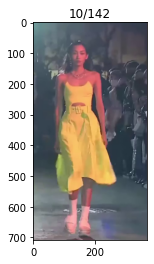

In [13]:
# take a look at the input video
MaxFrame = 10
frame_count = 1
try:
    while(frame_count <= MaxFrame):
        display.clear_output(wait=True)
        plt.title(str(frame_count)+'/'+str(total_frames))
        frame = vid.get_data(frame_count)  # Capture frame-by-frame
        frame_count += 1
        plt.imshow(frame)
        plt.pause(0.1)
except:
    print("Read video error!")

### Subject detection with FasterRCNN

In [14]:
import torchvision
from torchvision import transforms
import numpy as np

In [15]:
#Load Faster RCNN
FasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).eval().to(device)

In [16]:
rect_th=3
text_th=3
text_size=2
class_index = 1  # 1= people
score_threshold = 0.9  #threshold to recognize subject

In [17]:
# parameters for SlowFast
num_frames = 32
sampling_rate = 2
crop_size = 256

In [18]:
# SlowFast needs (num_frames * sampling_rate) frames 
SlowFastFrames = num_frames * sampling_rate
print(SlowFastFrames)

64


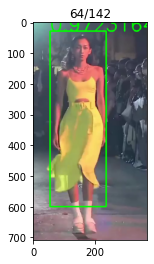

In [19]:
# collect bound boxes of subjects for (num_frames * sampling_rate) frames
# convert these bounding box to crop_size 
imgLst =[]
frame_count = 1
while(frame_count <= SlowFastFrames):
    display.clear_output(wait=True)
    plt.title(str(frame_count)+'/'+str(total_frames))
    
    frame = vid.get_data(frame_count)  # np array (H, W, 3)  
    
    transform = transforms.Compose([transforms.ToTensor()]) 
    img = transform(frame).to(device)  # torch (3, H, W)
    
    pred = FasterRCNN([img])[0]  
    
    bboxLabels = list(pred['labels'].cpu().numpy())
    bboxScore = list(pred['scores'].cpu().detach().numpy())
    mask=[]
    for i in range(len(bboxLabels)): #find bbox with score > threshold
        if(bboxLabels[i]==class_index and bboxScore[i]>=score_threshold):
            mask.append(i)
    boxes = pred["boxes"][mask].data.cpu().numpy()
    bboxScore = list(pred['scores'][mask].cpu().detach().numpy())        

    ### for this program, we only select the first bbox
    box0 = boxes[0]
    bboxScore0 = bboxScore[0]
    x1,y1,x2,y2 = box0
    
    #crop the image based on bbox 
    #torchvision.transforms.functional.crop(img: torch.Tensor, top, left, H, W)
    h = crop_size  # = 256, defined earlier for SlowFast
    w = crop_size
    cx = int((x1+x2)/2)
    cy = int((y1+y2)/2)
    img1 = transforms.functional.crop(img, int(cy-h/2), int(cx-w/2), h, w) 
    imgLst.append(img1.cpu())
    
    #display bbox
    cv2.rectangle(frame,(x1,y1),(x2,y2),color=(0,255,0),thickness=rect_th) 
    cv2.putText(frame,str(bboxScore0),(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,text_size,(0,255,0),thickness=text_th) 
    frame_count += 1
    plt.imshow(frame)
    plt.pause(0.1)

In [27]:
# torch.stack stacks a list of tensors
#a = [torch.FloatTensor([1, 2, 3]), torch.FloatTensor([3, 4, 5])]
#b = torch.stack(a)  
#tensor([[1., 2., 3.],
#        [3., 4., 5.]])

ImgsTensor = torch.stack(imgLst)  #stach a list of tensors 
print(ImgsTensor.shape)

torch.Size([64, 3, 256, 256])


In [28]:
# convert tensor shape from [64, 3, 256, 256] to [3, 64, 256, 256]
ImgsTensor = ImgsTensor.permute(1, 0, 2, 3) #swap axis 0 and 1
print(ImgsTensor.shape)

torch.Size([3, 64, 256, 256])


### Sent image frame tensor to SlowFast

In [29]:
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
slowfast_alpha = 4

In [30]:
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import NormalizeVideo
from pytorchvideo.transforms import UniformTemporalSubsample

In [31]:
transform=Compose(
    [
        UniformTemporalSubsample(num_frames),
        Lambda(lambda x: x/255.0),
        NormalizeVideo(mean, std),
    ])

In [32]:
fast_pathway = transform(ImgsTensor)
print(fast_pathway.shape)

torch.Size([3, 32, 256, 256])


In [33]:
slow_pathway = torch.index_select(
            fast_pathway,
            1,
            torch.linspace(
                0, fast_pathway.shape[1] - 1, fast_pathway.shape[1] // slowfast_alpha
            ).long(),
        )
print(slow_pathway.shape)

torch.Size([3, 8, 256, 256])


In [34]:
SlowFastInputFrames = [slow_pathway, fast_pathway]

In [35]:
SlowFastInputFrames = [i.to(device)[None, ...] for i in SlowFastInputFrames]

In [36]:
# Pass the input clip through the model
preds = SlowFastNet(SlowFastInputFrames)

In [37]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)

In [38]:
preds[0].topk(k=5)

torch.return_types.topk(
values=tensor([0.1128, 0.0589, 0.0475, 0.0399, 0.0314], device='cuda:0',
       grad_fn=<TopkBackward0>),
indices=tensor([ 84, 304, 326,  69,  16], device='cuda:0'))

In [39]:
print(preds[0].topk(k=5)[0], "\n", preds[0].topk(k=5)[1])

tensor([0.1128, 0.0589, 0.0475, 0.0399, 0.0314], device='cuda:0',
       grad_fn=<TopkBackward0>) 
 tensor([ 84, 304, 326,  69,  16], device='cuda:0')


In [40]:
pred_classes = preds[0].topk(k=5)[1]
print(pred_classes)

tensor([ 84, 304, 326,  69,  16], device='cuda:0')


In [41]:
# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: dancing ballet, singing, spinning poi, contact juggling, beatboxing


### Model Description
SlowFast model architectures are based on [1] with pretrained weights using the 8x8 setting
on the Kinetics dataset. 

| arch | depth | frame length x sample rate | top 1 | top 5 | Flops (G) | Params (M) |
| --------------- | ----------- | ----------- | ----------- | ----------- | ----------- |  ----------- | ----------- |
| SlowFast | R50   | 8x8                        | 76.94 | 92.69 | 65.71     | 34.57      |
| SlowFast | R101  | 8x8                        | 77.90 | 93.27 | 127.20    | 62.83      |


### References
[1] Christoph Feichtenhofer et al, "SlowFast Networks for Video Recognition"
https://arxiv.org/pdf/1812.03982.pdf